In [1]:
id_ = 'Zilionis_Klein_2019_NSCLC'
name = 'zilionis'
cell_key = 'cell_type_adjusted'
# id = 'Lambrechts_2018_LUAD_6149v1'
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries/'
load_wilcoxon = False
load_gsea = False
load_gsea_heatmap = False

In [2]:
id_ = 'Hu_Zhang_2023_NSCLC'
name = 'Hu'

# Cell Type Markers and GO

## Libraries and Data

We want to assign a cell type to our unsupervised clusters for tumor cells. For that we take the follwoing approach

1. Marker genes plots for these comparisons per cell type: (**TypeTumorPred** vs **REST**) 
2. Heatmaps With the above group as  cell labels and hierarchical clustering in the genes. With genes chosen from the marker genes.
3. Prevalent gene ontologies for the group above, considering also hallmark ontologies

In [3]:
import os
from pathlib import Path
import gdown

import sys
# This makes the working dir change apparently
sys.path.append("..")
import utils.functions as ut

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from scipy.sparse import csr_matrix

import anndata as ad
import scanpy as sc

In [4]:
# adata = sc.read_h5ad(f'{backup_dir}/combTumor_{id_}.h5ad')
time = 'I-IV'
adata = sc.read_h5ad(f'{backup_dir}/filtered_{id_}.h5ad')
# adata = sc.read_h5ad(f'{backup_dir}/{id_}.h5ad')
adata

AnnData object with n_obs × n_vars = 92330 × 24292
    obs: 'Sample', 'Patient', 'Resource', 'Sex', 'Age', 'Clinical Stage', 'Pathology', 'PD1 Antibody', 'Chemotherapy', 'Pathologic Response', 'Residual Tumor', 'RECIST', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [5]:
preds = pd.read_csv(f'{backup_dir}/{name}_predicted_leiden.csv')
preds.index = adata.obs.index
adata.obs[cell_key] = preds[cell_key]
adata.obs

,Sample,Patient,Resource,Sex,Age,Clinical Stage,Pathology,PD1 Antibody,Chemotherapy,Pathologic Response,...,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mito,log1p_total_counts_mito,pct_counts_mito,cell_type_adjusted
barcode,,,,,,,,,,,,,,,,,,,,,
BD_immune01_612637,BD_immune01,P01,Pre-treatment biopsy,Male,68.0,IIIA,Squamous,Toripalimab,Carboplatin+Docetaxel,NE,...,45924.0,10.734765,20.873617,28.157390,36.828238,50.973347,3062.0,8.027150,6.667538,Tumor LUAD_LUSC_mitotic
BD_immune01_698718,BD_immune01,P01,Pre-treatment biopsy,Male,68.0,IIIA,Squamous,Toripalimab,Carboplatin+Docetaxel,NE,...,41596.0,10.635783,17.605058,25.488028,34.859121,48.927782,1768.0,7.478170,4.250409,Tumor LUAD_LUSC_mitotic
BD_immune01_509246,BD_immune01,P01,Pre-treatment biopsy,Male,68.0,IIIA,Squamous,Toripalimab,Carboplatin+Docetaxel,NE,...,31883.0,10.369860,26.628611,33.183828,41.040680,53.690054,5425.0,8.598957,17.015339,Tumor LUAD_LUSC_mitotic
BD_immune01_101435,BD_immune01,P01,Pre-treatment biopsy,Male,68.0,IIIA,Squamous,Toripalimab,Carboplatin+Docetaxel,NE,...,31458.0,10.356441,17.795155,24.887151,33.784729,48.175345,2198.0,7.695758,6.987094,Tumor LUAD_LUSC_mitotic
BD_immune01_400370,BD_immune01,P01,Pre-treatment biopsy,Male,68.0,IIIA,Squamous,Toripalimab,Carboplatin+Docetaxel,NE,...,9912.0,9.201602,26.251009,35.401533,45.389427,59.927361,1073.0,6.979146,10.825262,T cell CD8 dividing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BD_immune13_111313,BD_immune13,P13,Post-treatment surgery,Male,59.0,IIIA,Squamous,Sintilimab,Carboplatin+Gemcitabine,NMPR,...,14235.0,9.563529,27.214612,34.092027,43.041798,57.267299,1400.0,7.244942,9.834914,Tumor LUAD_LUSC_mitotic
BD_immune13_791956,BD_immune13,P13,Post-treatment surgery,Male,59.0,IIIA,Squamous,Sintilimab,Carboplatin+Gemcitabine,NMPR,...,12655.0,9.445887,23.484789,31.600158,41.201106,55.827736,1075.0,6.981006,8.494666,Macrophage
BD_immune14_462072,BD_immune14,P14,Post-treatment surgery,Male,79.0,IIIA,Squamous,Sintilimab,Carboplatin+Gemcitabine,MPR,...,10994.0,9.305196,22.894306,30.598508,40.040022,55.512098,1039.0,6.946976,9.450609,B cell dividing


We confimr that we have counts and wilcoxon expects lognromalization so we normalize

Wilcoxon is rank based so apparently normalization is not necessary

In [7]:
adata[:20,10:20].to_df()

,AADACL2,AADACP1,AADAT,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARD,AARS
barcode,,,,,,,,,,
BD_immune01_612637,0.0,0.0,0.0,1.0,5.0,1.0,16.0,1.0,0.0,29.0
BD_immune01_698718,0.0,0.0,0.0,5.0,1.0,2.0,16.0,3.0,0.0,1.0
BD_immune01_509246,0.0,0.0,0.0,2.0,2.0,0.0,6.0,0.0,0.0,3.0
BD_immune01_101435,0.0,0.0,0.0,4.0,3.0,0.0,3.0,0.0,0.0,1.0
BD_immune01_400370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
BD_immune01_56414,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
BD_immune01_474207,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
BD_immune01_853648,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
BD_immune01_319054,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0


In [8]:
sc.pp.log1p(adata)
# adata.X = adata.layers['data']

In [9]:
adata[:20,10:20].to_df()

,AADACL2,AADACP1,AADAT,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARD,AARS
barcode,,,,,,,,,,
BD_immune01_612637,0.0,0.0,0.0,0.693147,1.791759,0.693147,2.833213,0.693147,0.0,3.401197
BD_immune01_698718,0.0,0.0,0.0,1.791759,0.693147,1.098612,2.833213,1.386294,0.0,0.693147
BD_immune01_509246,0.0,0.0,0.0,1.098612,1.098612,0.000000,1.945910,0.000000,0.0,1.386294
BD_immune01_101435,0.0,0.0,0.0,1.609438,1.386294,0.000000,1.386294,0.000000,0.0,0.693147
BD_immune01_400370,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.693147
BD_immune01_56414,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.098612,0.000000,0.0,0.000000
BD_immune01_474207,0.0,0.0,0.0,0.000000,0.693147,0.000000,1.098612,0.000000,0.0,0.000000
BD_immune01_853648,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.098612,0.000000,0.0,0.000000
BD_immune01_319054,0.0,0.0,0.0,0.000000,1.791759,0.000000,0.000000,0.000000,0.0,0.000000


## Marker Genes

We use th wilcoxon paired metho beacuse it considers hetorgeneity in te cell abundances. The one group vs rest does not do this.
So the idea is to first make all the pairwise comparisons and then do a summary of the stasticstics.

For that we have a method that automatically does the pairwise of a list of groups you give.

Then we choose the Rest Group and gather its stasticis in `.uns` key.  And then we have a method that takes the mean of those stastisitcs and outputs marker genes for every cell type vs. its rest.

In [10]:
adata.obs['type_tissue'] = adata.obs[cell_key]
adata.obs['type_tissue']

barcode
BD_immune01_612637    Tumor LUAD_LUSC_mitotic
BD_immune01_698718    Tumor LUAD_LUSC_mitotic
BD_immune01_509246    Tumor LUAD_LUSC_mitotic
BD_immune01_101435    Tumor LUAD_LUSC_mitotic
BD_immune01_400370        T cell CD8 dividing
                               ...           
BD_immune13_111313    Tumor LUAD_LUSC_mitotic
BD_immune13_791956                 Macrophage
BD_immune14_462072            B cell dividing
BD_immune14_124095            B cell dividing
BD_immune15_20126            NK cell dividing
Name: type_tissue, Length: 92330, dtype: object

### Pairwise

With parallel is shit! With 4 groups and 12 jobs it takes 26 min

Without parallel, still runs parallel from nnumpy in the scanpy method. With 4 groups it takes 12 min

TODO: Limit the number of cores this uses https://stackoverflow.com/questions/55746872/how-to-limit-number-of-cpus-used-by-a-python-script-w-o-terminal-or-multiproces

In [11]:
valid_types = list(adata.obs['type_tissue'].value_counts().loc[lambda x: x > 2].index)
types = adata.obs.type_tissue.unique()
w_folder = 'wilcoxon_DE'

# Load

all_path = f'{w_folder}/{time}_{id_}'
key_pair = "rank_genes_groups_tumor"

tumor_types = [g for g in valid_types if 'Tumor' in g]

Only if the vars are indexed as ensembl

In [ ]:
# ens = pd.read_csv(f'{backup_dir}/{name}/{name}_ensembl.csv', index_col=0a)
# adata.obs['ens'] = adata.obs.index
# ens

For the extended dataset and late stage cancer it took 6hours

In [ ]:
%%time

if load_wilcoxon:
    adata.uns[key_pair] = np.load(all_path + '_tumorpair.npy', allow_pickle='TRUE').item()
else:
    # TODO Adress this: is sensitive to the population composition, which introduces an element of unpredictability to the marker sets due to variation in cell type abundances
    # Solved by using pairwise wilcoxon
    results = ut.rank_genes_groups_pairwise(adata, 'type_tissue', method='wilcoxon', use_raw=False,
                       groups=valid_types, subgroups=tumor_types, parallel=False)
    adata.uns[key_pair] = results
    np.save(all_path + '_tumorpair.npy', adata.uns[key_pair])

Comparing Tumor LUAD_LUSC_mitotic_vs_Macrophage
Comparing Tumor LUAD_LUSC_mitotic_vs_T cell CD4
Comparing Tumor LUAD_LUSC_mitotic_vs_Neutrophils
Comparing Tumor LUAD_LUSC_mitotic_vs_T cell CD8 effector memory
Comparing Tumor LUAD_LUSC_mitotic_vs_B cell
Comparing Tumor LUAD_LUSC_mitotic_vs_T cell CD8 terminally exhausted
Comparing Tumor LUAD_LUSC_mitotic_vs_T cell regulatory
Comparing Tumor LUAD_LUSC_mitotic_vs_Plasma cell
Comparing Tumor LUAD_LUSC_mitotic_vs_Monocyte classical
Comparing Tumor LUAD_LUSC_mitotic_vs_Macrophage alveolar
Comparing Tumor LUAD_LUSC_mitotic_vs_NK cell
Comparing Tumor LUAD_LUSC_mitotic_vs_Tumor LUAD_mitotic
Comparing Tumor LUAD_LUSC_mitotic_vs_T cell NK-like
Comparing Tumor LUAD_LUSC_mitotic_vs_T cell CD8 naive
Comparing Tumor LUAD_LUSC_mitotic_vs_T cell CD8 dividing
Comparing Tumor LUAD_LUSC_mitotic_vs_Mast cell
Comparing Tumor LUAD_LUSC_mitotic_vs_T cell CD8 activated
Comparing Tumor LUAD_LUSC_mitotic_vs_Ciliated
Comparing Tumor LUAD_LUSC_mitotic_vs_Alveolar 

### Summaries

In [ ]:
results = adata.uns[key_pair]

In [ ]:
import multiprocessing
def process_gene(group1, pairwise_dict, groups2):
    scores = {}
    genes = next(iter(results.items()))[1]['names']
    comparisons = [(group1, group2) for group2 in groups2 if group1 != group2]
    
    for gene in genes:
        comparison_scores = []
        for comparison in comparisons:
            comp_key = f'{comparison[0]}_vs_{comparison[1]}'
            gene_index = np.where(results[comp_key]['names'] == gene)[0]
            comparison_scores.append(results[comp_key]['scores'][gene_index][0])
        scores[gene] = comparison_scores
    return group1, scores

num_processes = 40

Tumor against all

In [ ]:
%%time
groups = [ group for group in valid_types if 'Tumor' in group]
scores_dict = {group: {} for group in groups}

with multiprocessing.Pool(num_processes) as pool:
    for group_scores in pool.starmap(process_gene, [(group1, results, valid_types) for group1 in groups]):
        scores_dict[group_scores[0]] = group_scores[1]

adata.uns['rank_genes_groups_summary_tumorall'] = scores_dict

We make it mimic the structure that the scanpy tool for ranking genes already has to be able to work with our other methods.

In [ ]:
%%time
regions = ['tumorall']
# regions = ['normalall']

for region in regions:
    if load_wilcoxon:
        adata.uns[f'rank_genes_groups_{region}'] = np.load(all_path + f'_{region}.npy', allow_pickle=True).item()
        continue

    regioner = {cell_type: {gene: np.mean(scores) for gene, scores in genes_dict.items()}
                    for cell_type, genes_dict in adata.uns[f'rank_genes_groups_summary_{region}'].items()}
    regioner = {cell_type: sorted(genes.items(), key=lambda k: k[1], reverse=True) for cell_type, genes in regioner.items()}

    types_num = len(regioner)
    genes_num = len(next(iter(results.values()))['names'])
    scores = [[None] * genes_num for _ in range(types_num)]
    names = [[None] * genes_num for _ in range(types_num)]
    
    for i, cell_type in enumerate(regioner.keys()):
        j = 0
        for gene, score in regioner[cell_type]:
            scores[i][j] = score
            names[i][j] = gene
            j += 1

    names_zip = list(zip(*names))
    dtypes = [(typer, float) for typer in regioner.keys()]
    dtypes_names = [(typer, 'O') for typer in regioner.keys()]

    i = 0
    for n_scores in zip(*scores):
        if i==0:
            rank_scores = np.rec.array([n_scores], dtype=dtypes)
            rank_names = np.rec.array([names_zip[i]], dtype=dtypes_names)
        else:
            temp_scores = np.rec.array([n_scores], dtype=dtypes)
            rank_scores = np.rec.array(np.concatenate((rank_scores, temp_scores)))
    
            temp_names = np.rec.array([names_zip[i]], dtype=dtypes_names)
            rank_names = np.rec.array(np.concatenate((rank_names, temp_names)))
        i += 1

    rec_region = {'params': {'groupby': 'type_tissue', 'reference': region, 'method': 'wilcoxon', 'use_raw': False, 'layer': None, 'corr_method': 'benjamini-hochberg'}}
    rec_region['names'] = rank_names
    rec_region['scores'] = rank_scores

    adata.uns[f'rank_genes_groups_{region}'] = rec_region
    np.save(all_path + f'_{region}.npy', adata.uns[f'rank_genes_groups_{region}'])

In [ ]:
[ keyer  for keyer in adata.uns.keys() if 'rank_genes' in keyer]

### Plotting

In [ ]:
def cond_plot(adata, cond_types, valid_types, ax=None,
              key='wilcoxon', fontsize=9, titlesize=14, **kwds):
    if set(cond_types).issubset(valid_types):
        ut.rank_genes_group(adata, cond_types[0], n_genes=n_genes,
                            ax=ax, sharey=False, key=key, show=False,
                            fontsize=fontsize, titlesize=titlesize)
    else:
        # pass
        # Draw an empty plot with a message
        ax.text(0.5, 0.5, f'Missing cells: {cond_types}', color='red', 
                       ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')

In [ ]:
region = 'tumorall'
types = adata.uns[f'rank_genes_groups_{region}']['scores'].dtype.names
num_types = len(types)
fig, axs = plt.subplots(num_types, 1, figsize=(1, 4.5*(num_types)))
n_genes = 20
for i, type in enumerate(types):
    # tumor_tumor = type + '_TT_Tumor'
    # normal_tumor = type + '_TT_Normal'
    titlesize = 9
    fontsize = 6

    
    cond_plot(adata, [type], valid_types, n_genes=n_genes,
                     ax= axs[i, 0], sharey=False, key=f'rank_genes_groups_{region}', show=False,
                     fontsize=fontsize, titlesize=titlesize)
    # cond_plot(adata, [type], valid_types, n_genes=n_genes,
    #                  ax= axs[i, 1], sharey=False, key=f'rank_genes_groups_onlytumor', show=False,
    #                  fontsize=fontsize, titlesize=titlesize)
    # cond_plot(adata, [tumor_tumor, normal_tumor], valid_types, n_genes=n_genes, ax= axs[i, 1],
    #                         key=f"w_pair_{type}_differ", show=False,
    #                  fontsize=fontsize, titlesize=titlesize)

# Display the entire figure with all plots
plt.show()

## Heatmaps

To show heatmap we need the logfold changes also...

         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):
/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


categories: Airway epithelium_TT_Normal, Airway epithelium_TT_Tumor, Alveolar epithelium_TT_Normal, etc.
var_group_labels: Lymphoid_TT_Normal, Myeloid_TT_Normal, Airway epithelium_TT_Tumor, etc.


/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


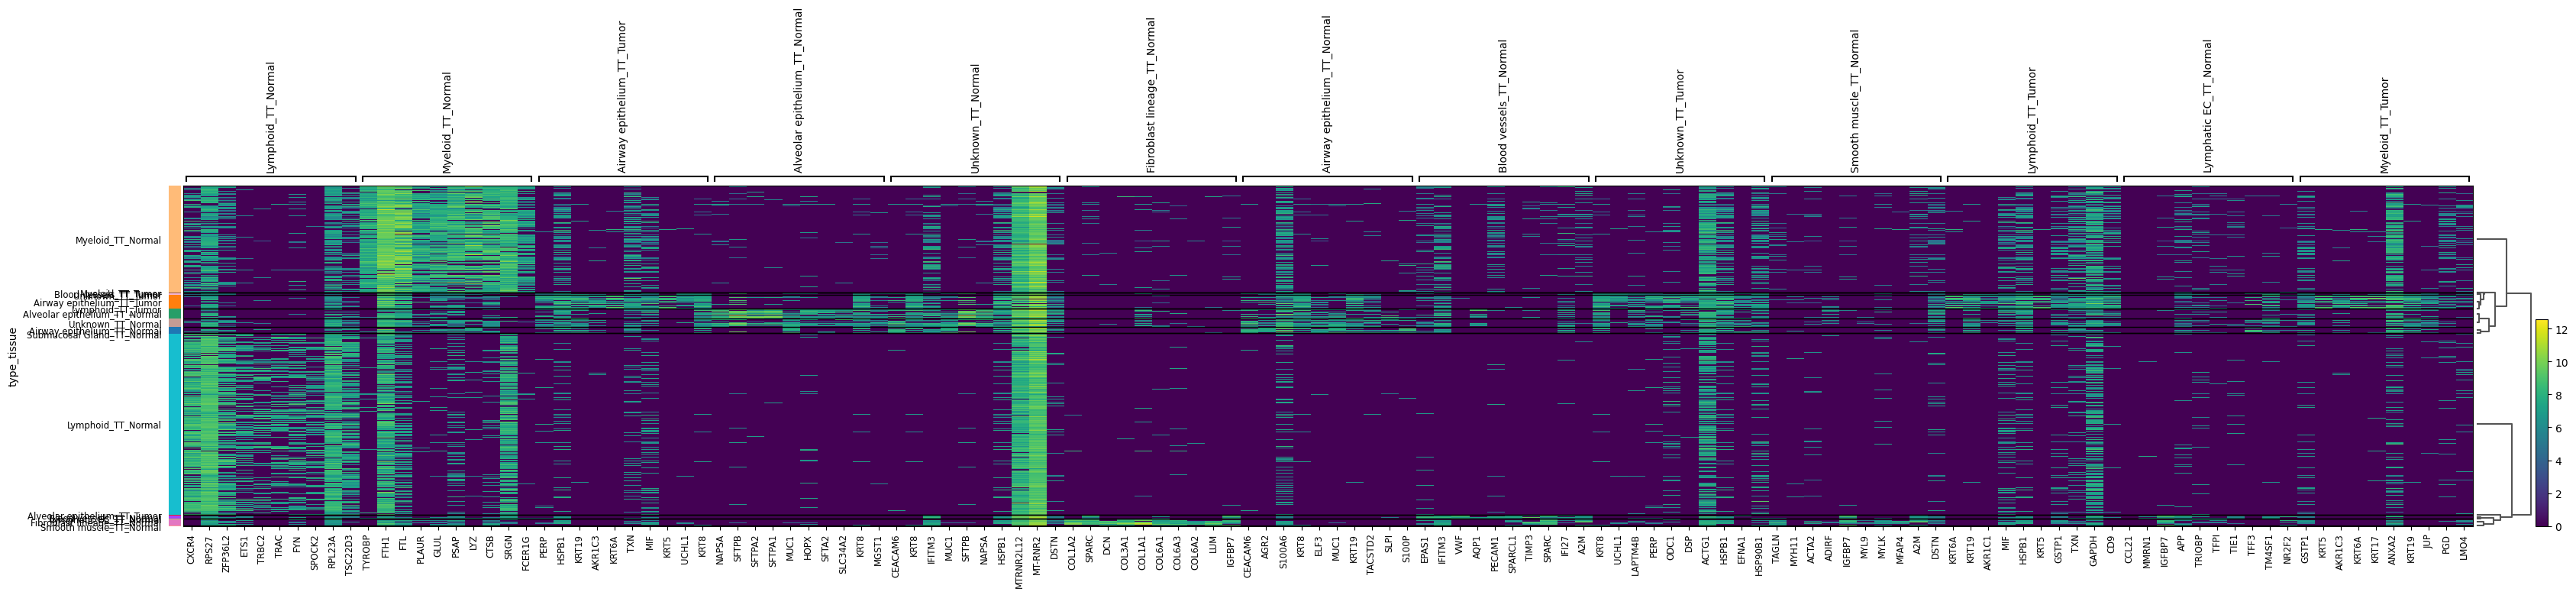

In [24]:
sc.pl.rank_genes_groups_heatmap(adata, show_gene_labels=True, key='wilcoxon')

## GSEA

In [38]:
from gprofiler import GProfiler
import gseapy
import seaborn as sns
gp = GProfiler(return_dataframe=True, user_agent='INMEGEN')

In [39]:
# gen_list = adata.uns['wilcoxon']['names']['Airway epithelium_TT_Tumor'][100:]
# enrich = gp.profile(list(gen_list), sources=['GO:BP'], organism="hsapiens")
# enrich.iloc[:25,:]

In [40]:
#  Download Gene symbols
if not os.path.exists('h.all.v2023.2.Hs.symbols.gmt'):
    ! wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/h.all.v2023.2.Hs.symbols.gmt

#  Gene entrez
# if not os.path.exists('h.all.v2023.2.Hs.entrez.gmt'):
# ! wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/h.all.v2023.2.Hs.entrez.gmt

In [41]:
from typing import List

def get_gseas_df(adata: ad.AnnData, valid_types: List[str],
                 types: List[str], id_: str, load_gsea: bool = False,
                 key:str = 'rank_gene_groups', gsea_folder:str = 'gseapy_gsea') -> pd.DataFrame:
    """
    Generates a combined DataFrame from GSEA results for different cell types.

    Args:
    adata (ad.AnnData): An AnnData object containing the dataset.
    valid_types (List[str]): A list of valid cell types to filter the cell types.
    types (List[str]): A list of cell types to be considered for analysis.
    id_ (str): Identifier used in generating the GSEA path.
    load_gsea (bool, optional): Flag to load existing GSEA results. Defaults to False.

    Returns:
    pd.DataFrame: A combined DataFrame with GSEA results pivoted by cell type and hallmark.

    The function uses the provided 'types', intersects them with 'valid_types',
    and computes GSEA for each type. The final DataFrame is a pivot table with cell types as rows
    and GSEA hallmarks as columns.
    """
    # Intersect types with valid types
    types = set(types).intersection(valid_types)
    dfs = []

    for type in types:
        ranks = adata.uns[key]
        type_path = type.replace('/','_')
        gsea_path = f'{gsea_folder}/{type_path}_{id_}.npz'

        # Generate gene scores
        gene_scores = {gene: ranks['scores'][type][i] for i, gene in enumerate(ranks['names'][type])}
        gene_scores = pd.Series(gene_scores)

        # Run GSEA
        if load_gsea:
            gseas = np.load(gsea_path, allow_pickle='TRUE').item()
        else:
            pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
                                     processes=20, permutation_num=100, seed=6, no_plot=True)
            gseas = pre_res.res2d
            np.save(gsea_path, gseas)

        data1 = {'hallmark': list(gseas['Term'].str.slice(9)), 'score': list(gseas['NES'])}
        df_celltype1 = pd.DataFrame(data1)
        df_celltype1['cell_type'] = type
        dfs.append(df_celltype1)

    # Combine all DataFrames
    combined_df = pd.concat(dfs).reset_index(drop=True).pivot(index='cell_type', columns='hallmark', values='score')
    return combined_df

In [45]:
%%time
#papermill_description=GSEA
gsea_folder = 'gseapy_gsea'
combined_dfs = {}

for region in regions:
    gsea_path = f'{gsea_folder}/heatmap_{region}_{time}.csv'
    if load_gsea_heatmap:
        combined_dfs[region] = pd.read_csv(gsea_path, index_col=0)
    else:
        types = adata.uns[f'rank_genes_groups_{region}']['scores'].dtype.names
        combined_dfs[region] = get_gseas_df(adata, valid_types, types, id_, load_gsea=False, key=f'rank_genes_groups_{region}')
        combined_dfs[region].to_csv(gsea_path)

/tmp/ipykernel_145298/3327198433.py:40: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-06-14 23:56:37,876 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
/tmp/ipykernel_145298/3327198433.py:40: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-06-14 23:56:38,663 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
/tmp/ipykernel_145298/3327198433.py:40: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-06-14 23:56:39,269 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The orde

CPU times: user 3min 28s, sys: 14.7 s, total: 3min 43s
Wall time: 1min


In [33]:
combined_dfs[region]

hallmark,ADIPOGENESIS,ALLOGRAFT_REJECTION,ANDROGEN_RESPONSE,ANGIOGENESIS,APICAL_JUNCTION,APICAL_SURFACE,APOPTOSIS,BILE_ACID_METABOLISM,CHOLESTEROL_HOMEOSTASIS,COAGULATION,...,PROTEIN_SECRETION,REACTIVE_OXYGEN_SPECIES_PATHWAY,SPERMATOGENESIS,TGF_BETA_SIGNALING,TNFA_SIGNALING_VIA_NFKB,UNFOLDED_PROTEIN_RESPONSE,UV_RESPONSE_DN,UV_RESPONSE_UP,WNT_BETA_CATENIN_SIGNALING,XENOBIOTIC_METABOLISM
cell_type,,,,,,,,,,,,,,,,,,,,,
Tumor cells LUAD,1.385179,-1.000000,1.327392,0.898662,0.975571,0.961109,1.003821,1.019825,1.490762,1.176540,...,1.621359,1.415603,1.045800,0.911878,-1.000000,1.406214,1.120867,1.009145,0.765120,1.385751
Tumor cells LUAD EMT,0.962979,-1.698852,-1.297952,1.385156,-1.147256,-0.743597,-1.372340,-1.305298,1.018020,-1.013391,...,-1.006692,1.592662,0.633768,-1.293659,-1.720307,-1.067344,1.043090,-1.483855,0.973137,1.132077
Tumor cells LUAD MSLN,1.205333,0.721505,1.245030,1.239334,1.101454,1.045558,1.100449,1.054247,1.244188,1.131000,...,1.362180,1.048373,0.950002,1.072134,0.948464,1.235048,1.099807,1.140690,0.870975,1.185255
Tumor cells LUAD NE,1.108878,-1.000000,1.050197,0.676721,0.925393,1.060494,0.875229,0.997833,1.139776,0.572162,...,1.302258,1.096325,1.109654,0.900400,0.667036,1.315554,0.978590,1.028570,0.965479,1.106298
Tumor cells LUAD mitotic,1.211308,-1.000000,1.080180,-1.306534,0.976211,0.959492,1.129360,0.852761,1.355446,1.131085,...,1.435936,1.264051,1.229550,0.784730,-1.000000,1.191127,1.038920,1.032342,0.801956,1.146589
Tumor cells LUSC,1.362146,-2.268965,-1.004088,-1.060499,0.947719,1.162958,-1.052432,0.821036,1.308656,-1.234129,...,1.324436,1.636218,1.362052,-1.419960,-1.835468,1.059770,-0.952888,1.000061,0.781523,1.557828
Tumor cells LUSC mitotic,1.270469,-1.000000,0.935149,-1.296147,0.782493,1.078952,0.813501,0.940703,1.264724,-1.203123,...,1.263732,1.471365,1.576645,-1.160731,-1.000000,1.310929,-0.880739,1.057436,0.790173,1.289721
Tumor cells NSCLC mixed,-1.244759,-2.045948,1.075813,-1.245467,1.175175,1.340076,-1.038423,-0.833133,1.300499,1.010599,...,1.019497,-1.303180,-0.813187,-1.095983,-1.135068,-1.164943,-0.914398,-1.121742,-1.144146,-1.000073


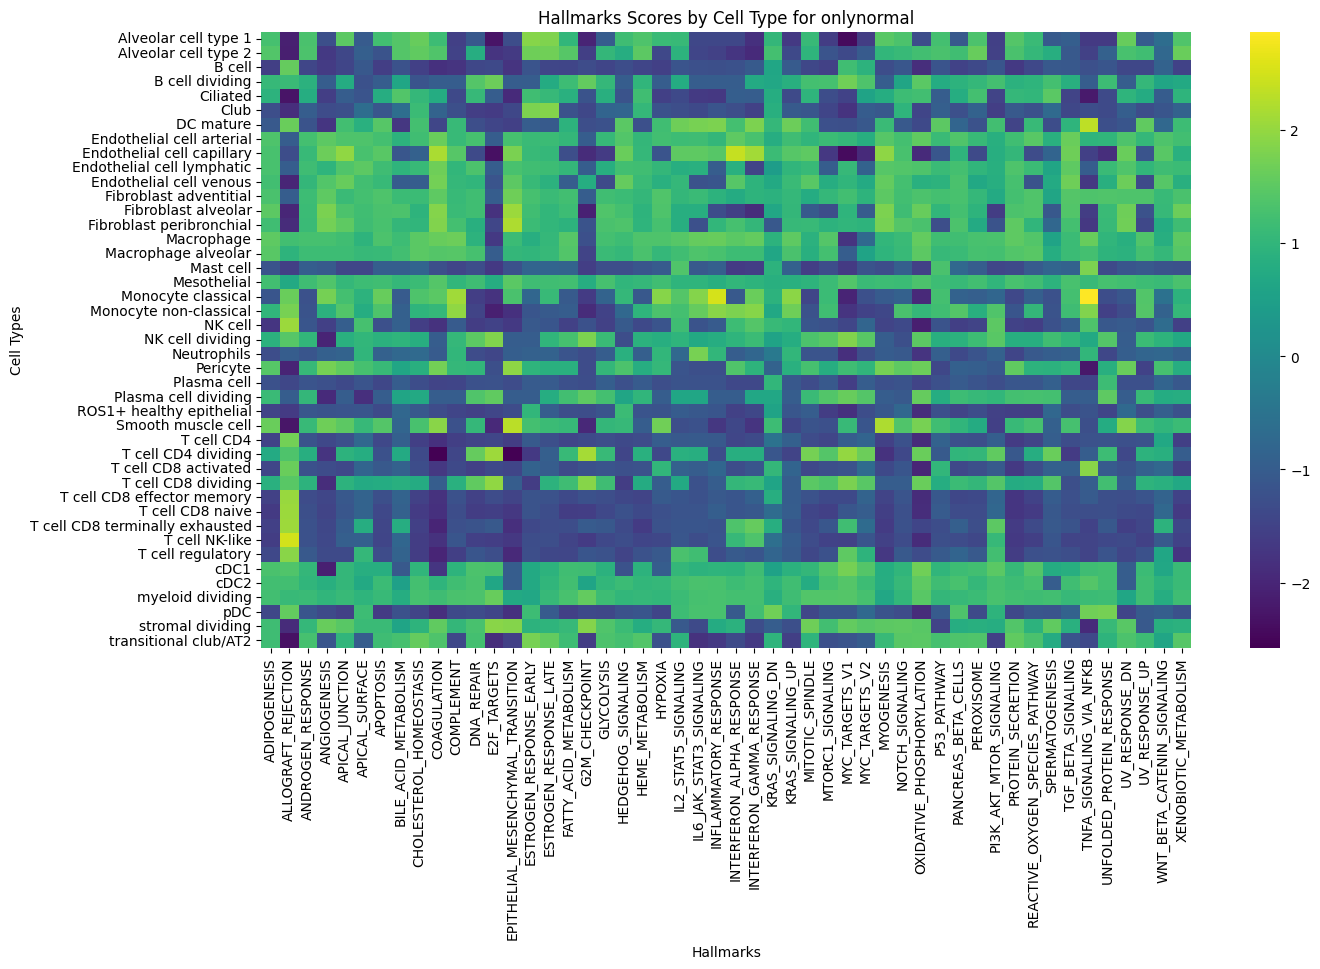

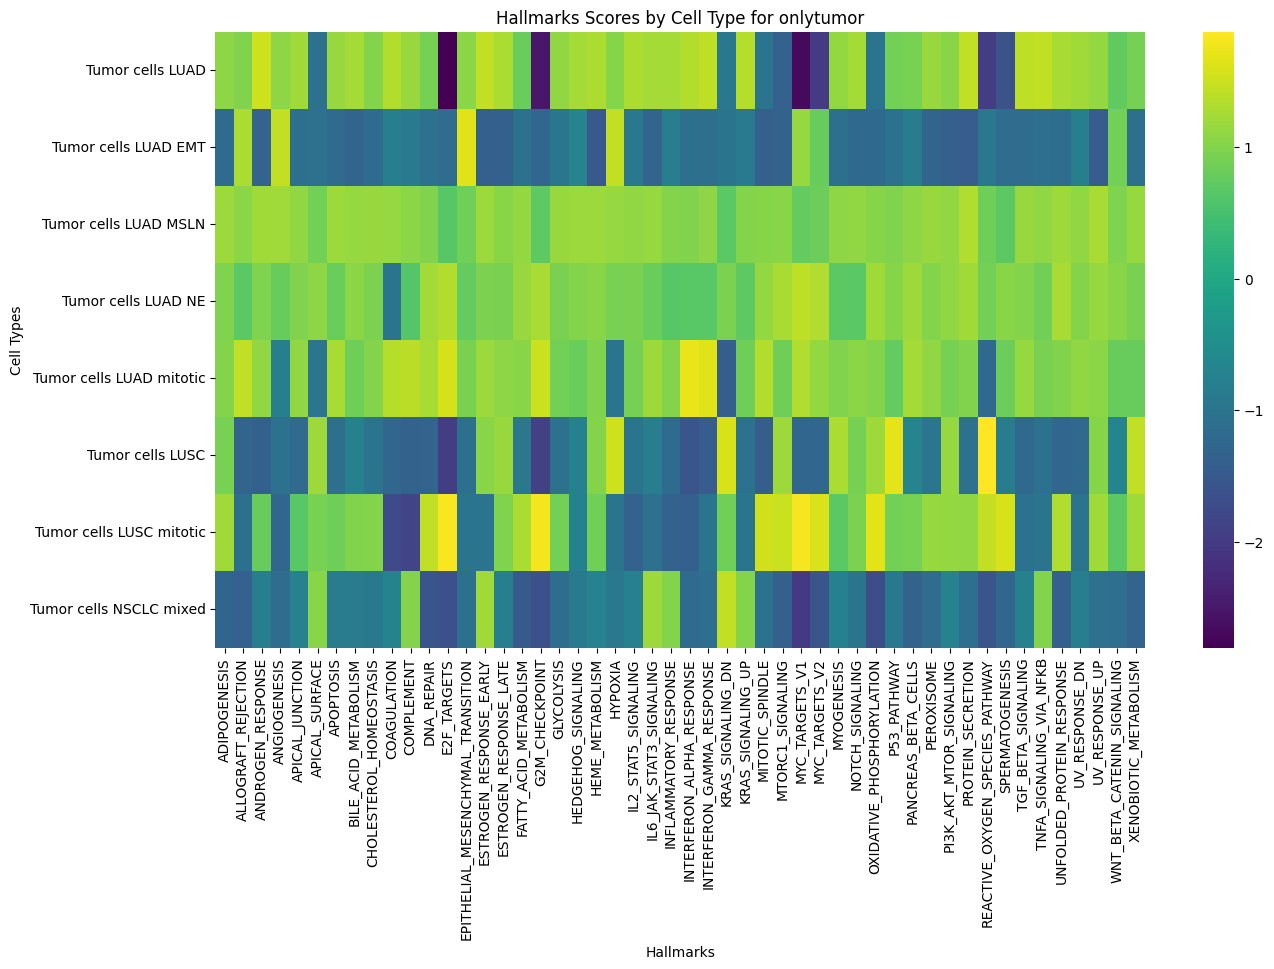

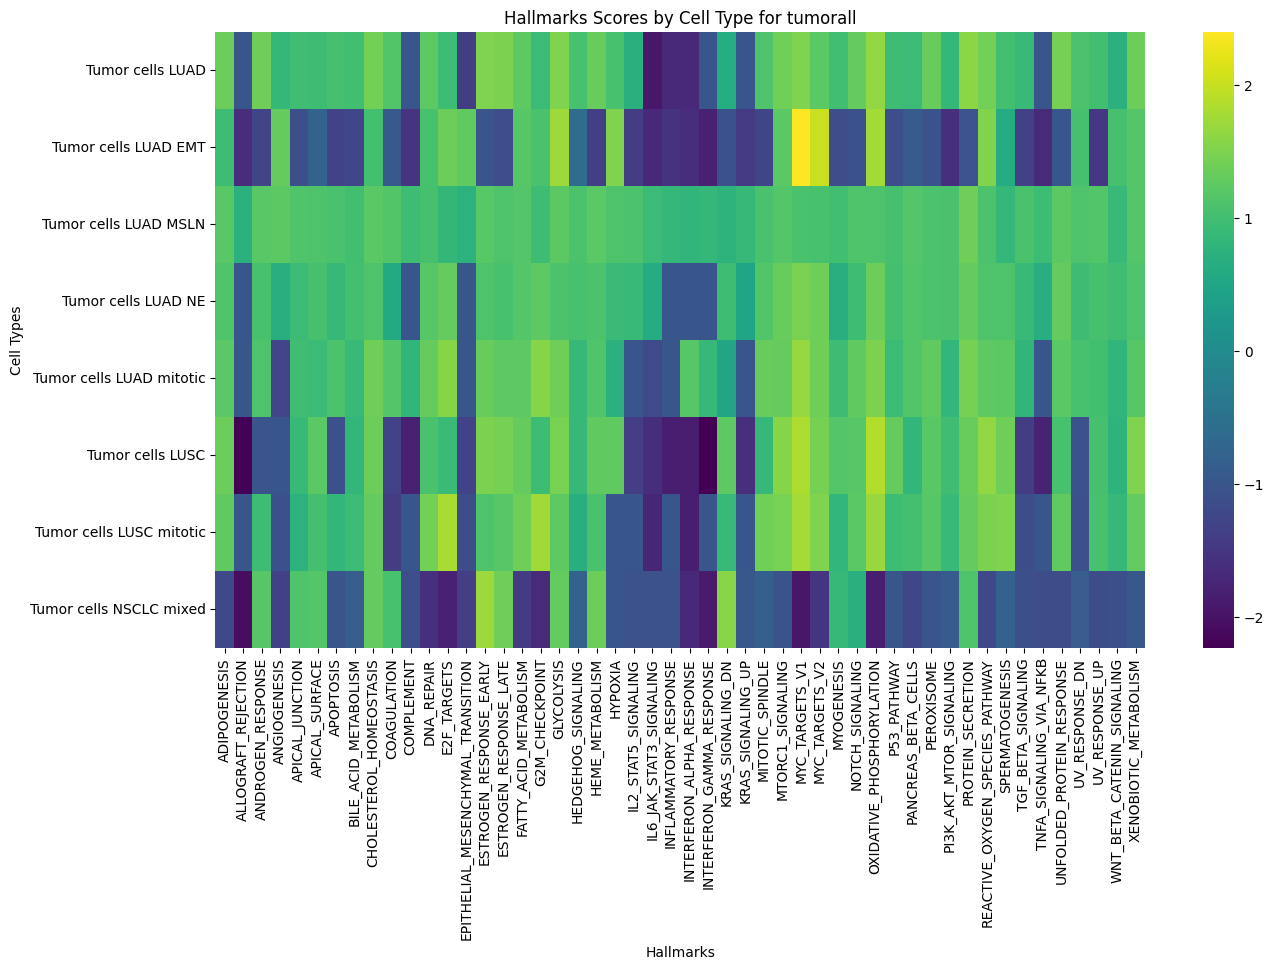

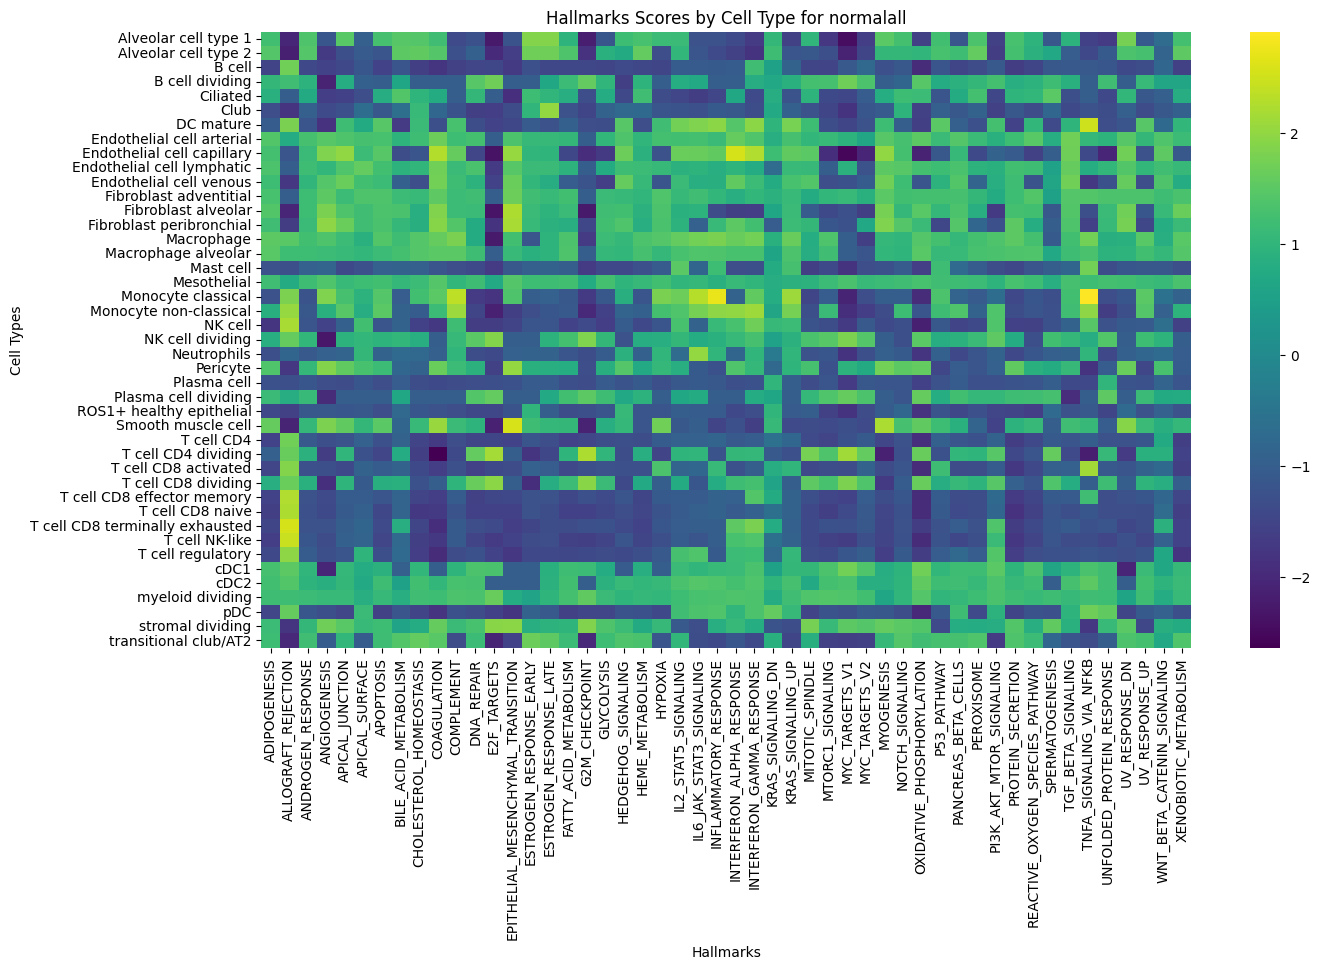

In [46]:
# Plotting the heatmap
# combined_df_tumor = combined_df.loc[combined_df.index.str.split('_').str[-1] == 'Tumor']
for region in regions:
    plt.figure(figsize=(15, 8))
    sns.heatmap(combined_dfs[region], cmap='viridis')
    plt.title(f'Hallmarks Scores by Cell Type for {region}')
    plt.xlabel('Hallmarks')
    plt.ylabel('Cell Types')
    plt.show()

## Pseudotime

In [90]:
adata_tumor

View of AnnData object with n_obs × n_vars = 46473 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'type_tissue',

In [104]:
sc.pl.draw_graph(adata_t_b)

KeyError: 'draw_graph'

In [ ]:
adata.obs['cell_type_tumor']

In [97]:
# adata_normal = adata[np.logical_not(adata.obs['cell_type_tumor'].str.contains('Tumor'))]
adata_t_b = adata[np.logical_or(adata.obs['cell_type_tumor'].str.contains('T cell'), adata.obs['cell_type_tumor'].str.contains('B cell'))]

In [98]:
sc.tl.diffmap(adata_t_b)

/usr/local/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:933: RuntimeWarning: divide by zero encountered in divide
  Q = scipy.sparse.spdiags(1.0 / q, 0, W.shape[0], W.shape[0])
/usr/local/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:943: RuntimeWarning: divide by zero encountered in divide
  self.Z = scipy.sparse.spdiags(1.0 / z, 0, K.shape[0], K.shape[0])


ArpackNoConvergence: ARPACK error -1: No convergence (504391 iterations, 2/15 eigenvectors converged)